In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import glob
import os

# Replace the origin string with your specific WebSocket origin to allow use of the Phoenix dashboard
os.environ["BOKEH_ALLOW_WS_ORIGIN"] = "0klvo4n67bg2u6fr7kngsi6ip1kop1nps068mq9f8l8tfo4s604b"

import warnings

import astropy.units as u
from astropy.modeling import models
from astroquery.nist import Nist # atomic lines
# from astroquery.linelists.cdms import CDMS # molecular lines?

from muler.igrins import IGRINSSpectrum, IGRINSSpectrumList

from tqdm import tqdm

from gollum.phoenix import PHOENIXSpectrum, PHOENIXGrid
from muler.hpf import HPFSpectrumList
from specutils import SpectralRegion
from specutils.manipulation import extract_region
from specutils.fitting import find_lines_derivative, fit_continuum

# %config InlineBackend.figure_format='retina'

from astropy.io import fits

# Plotting Parameters
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18

plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20

plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

%matplotlib inline

In [2]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

# Reduced and order-merged data filepath 
# Laptop Path
data_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-Spectra\\IGRINS_Merged"

# File path for figures to live in
fig_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-SpectraIGRINS_figs\\standards_spectra"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
# merged_standard_files = glob.glob(data_path + "/merged_standards/m*.fits")
standard_table = pd.read_csv('C:\\Users\\Savio\\Documents\\IGRINS-Spectra\\standard_table_v3.txt', index_col=0)  # csv of standards with file and Spectral Type, c/v TBA
# just a pick a sequence of standards to look at: ["LkCa1","HBC427","Hubble4","Anon1","LkCa5","MHO8"])]
# Symposium sequence: ["LkCa19","HBC427","Hubble4","Anon1","HBC359","LkCa21","LkCa1","MHO8"]
# standard_table = standard_table[standard_table['Name'].isin(["LkCa19","HBC427","Hubble4","Anon1","HBC359","LkCa21","LkCa1","MHO8"])].reset_index(drop=True)

proto_table = pd.read_csv('C:\\Users\\Savio\\Documents\\IGRINS-Spectra\\protostar_table.txt', index_col=0)

standards_path = standard_table['File']
standard_list = standard_table['File'].values

proto_path = proto_table['File']
proto_list = proto_table['File'].values

In [3]:
# Directly query NIST to find line features in K-band
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore') 
    lines_table = Nist.query(2.08*u.um,2.35*u.um,
                    linename = 'Na I, Sc I, Si I, Fe I, Al I, Mg I, Ca I, H I, Ti I',
                    energy_level_unit='eV',output_order='wavelength')

igrins_wav_cut = (lines_table['Observed'] > 2.08) & (lines_table['Observed'] < 2.35)
lines_table = lines_table[igrins_wav_cut]
# lines_table = pd.read_csv('lines_table.txt')

# Make masks for the table of all the lines just in case I want to peek at certain transitions/wavelengths
na1_mask = lines_table['Spectrum'] == 'Na I'
sc1_mask = lines_table['Spectrum'] == 'Sc I'
si1_mask = lines_table['Spectrum'] == 'Si I'
fe1_mask = lines_table['Spectrum'] == 'Fe I'
al1_mask = lines_table['Spectrum'] == 'Al I'
mg1_mask = lines_table['Spectrum'] == 'Mg I'
ca1_mask = lines_table['Spectrum'] == 'Ca I'
h1_mask  = lines_table['Spectrum'] == 'H I'
ti1_mask = lines_table['Spectrum'] == 'Ti I'

# Just add all the masks to a list for the sake of my plotting a few cells down
mask_list = [na1_mask,sc1_mask,si1_mask,fe1_mask,al1_mask,mg1_mask,ca1_mask,h1_mask,ti1_mask]
color_list = ['purple', 'orange', 'green', 'blue', 'brown', 'crimson', 'olive', 'cyan', 'darkgreen']

na_reg_lines = sorted([lines_table[na1_mask][0]['Observed'],
                lines_table[sc1_mask][19]['Observed'],
                lines_table[si1_mask][2]['Observed'],
                lines_table[sc1_mask][20]['Observed'],
                lines_table[na1_mask][1]['Observed']])

na_reg_lines = np.array(na_reg_lines)

ti_reg_lines = np.array([lines_table[ti1_mask]['Observed'][44],
        lines_table[ti1_mask]['Observed'][45],
        lines_table[fe1_mask]['Observed'][85],
        lines_table[fe1_mask]['Observed'][86],
        lines_table[ti1_mask]['Observed'][47]])

ca_reg_lines = list(lines_table[ca1_mask]['Observed'][:]) # list of Ca I lab wavelengths
ca_reg_lines.append(lines_table[fe1_mask]['Observed'][104])
ca_reg_lines = np.array(sorted(ca_reg_lines))

In [4]:
na_reg_lines, ti_reg_lines, ca_reg_lines

wavmin = 2.2*1e4
wavmax = 2.29*1e4

# PHOENIX MODELS

In [5]:
phoenix_mod_path = "C:\\Users\\Savio\\Documents\\Research\\phoenix_models\\phoenix.astro.physik.uni-goettingen.de\\HiResFITS\\"

In [6]:
wavmin = 2.1*1e4
wavmax = 2.35*1e4

spec_list = []
for i in tqdm(range(len(standard_table))):
    spec = IGRINSSpectrumList.read(standard_table['File'][i])\
        .trim_overlap().stitch()
    # spec = spec[10:-5]
    spec = spec.apply_boolean_mask(mask=(~np.isnan(spec.wavelength.value)) & 
                                    (spec.wavelength.value > wavmin) & 
                                    (spec.wavelength.value < wavmax)
                                    ).normalize().remove_nans()#.smooth_spectrum(bandwidth=10)
    # spec_list.append(spec)
    spec_list.append(spec.normalize())
    # spec[15].plot()

100%|██████████| 23/23 [00:05<00:00,  4.09it/s]


<Axes: xlabel='$\\lambda \\;(\\AA)$', ylabel='Flux'>

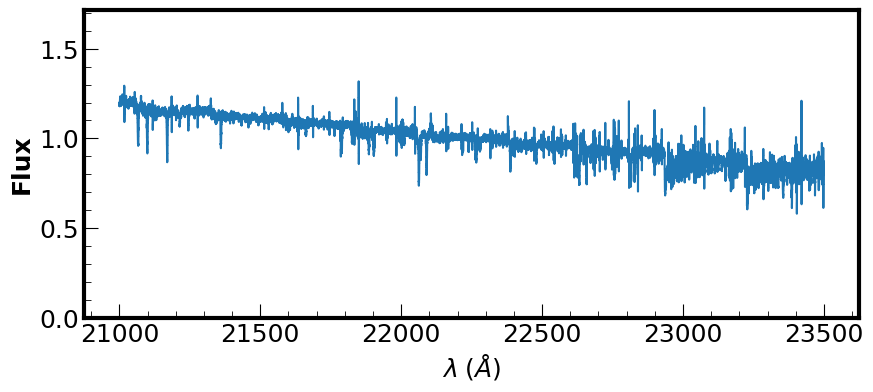

In [7]:
spec_list[2].plot()
# plt.xlim(22000,22300)

In [8]:
proto_spec_list = []
for i in tqdm(range(len(proto_table))):
    proto_spec = IGRINSSpectrumList.read(proto_table['File'][i])\
        .trim_overlap().stitch()
    # spec = spec[10:-5]
    proto_spec = proto_spec.apply_boolean_mask(mask=(~np.isnan(proto_spec.wavelength.value)) & 
                                    (proto_spec.wavelength.value > 2.05*1e4) & 
                                    (proto_spec.wavelength.value < 2.35*1e4))
    #                                 ).normalize()#.smooth_spectrum(bandwidth=10)
    # spec_list.append(spec)
    proto_spec_list.append(proto_spec)
    # proto_spec.plot()

100%|██████████| 48/48 [00:10<00:00,  4.51it/s]


# Use PHOENIX Dashboard to manually fit T_eff (and log g?)

In [9]:


grid = PHOENIXGrid(teff_range=(2300, 5800),
                   logg_range=(0, 6),
                   Z_range=(0,0.5),
                   wl_lo=wavmin,
                   wl_hi=wavmax,
                   path=phoenix_mod_path
                  )

Processing Teff=5800K|log(g)=6.00|Z=+0.5: 100%|██████████| 936/936 [00:49<00:00, 19.05it/s]


In [10]:
# grid.show_dashboard(spec_list[3])

# Try to fit parameters programatically

In [11]:
vsinis = np.linspace(1, 150, 50)
rvs = np.linspace(-100, 100, 50)
# try to add veiling?
veil_grid = np.linspace(0,3,50)

search_vsini, search_rv = np.meshgrid(vsinis, rvs, indexing='ij')

@np.vectorize
def chi_squared_vels(spectrum, teff_guess, logg_guess, vsini, rv):
    '''
    spectrum = index in spec_list
    teff_guess = float, must be in steps of 100 K from 2300-7000 K
    logg_guess = float, must be in steps of 0.5 from 0-6
    vsini = float
    rv = float
    
    '''
    model = PHOENIXSpectrum(teff=teff_guess,
                            logg=logg_guess,
                            Z=0,
                            wl_lo=wavmin,
                            wl_hi=wavmax,
                            path=phoenix_mod_path
                            ).rotationally_broaden(vsini)\
                            .rv_shift(rv)\
                            .resample(spec_list[spectrum])\
                            .normalize()\
                            .instrumental_broaden(45000)
    
    # Flux and uncertainties
    observed_flux = spec_list[spectrum].flux
    model_flux = model.flux
    uncertainty = spec_list[spectrum].uncertainty.array  # Array of flux uncertainties
    
    # Compute chi-squared
    chi_squared = np.nansum(
        (observed_flux - model_flux)**2 / uncertainty** 2
        )
    return chi_squared

In [12]:
spectrum_n = 3 # index for spec_list (list of Spectrum1D objects)
t_guess = (np.round(standard_table['PM_Teff']/100)*100) # list of initial guesses for Temperature based on spectral type
logg_guess = 3.5 # initial guess for log g based on vibes

# calculate the chi-squared along each grid point
chi2_grid = chi_squared_vels(spectrum_n,
                             int(t_guess[spectrum_n]),
                             logg_guess,
                             search_vsini,
                             search_rv
                             )
# find the index for the best fitting vsini and r_v
min_index = np.unravel_index(np.argmin(chi2_grid), chi2_grid.shape)
best_vsini = search_vsini[min_index]
best_rv = search_rv[min_index]
print(f"Best vsini: {best_vsini}, Best RV: {best_rv}")

Best vsini: 16.20408163265306, Best RV: -2.040816326530603


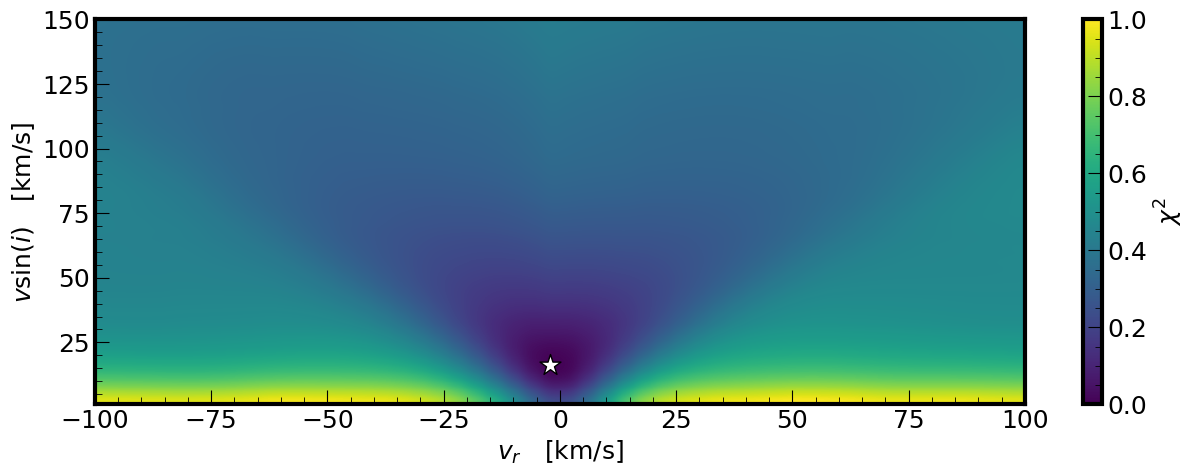

In [13]:
plt.imshow(chi2_grid, extent=[rvs.min(), rvs.max(), vsinis.min(), vsinis.max()], aspect='auto', origin='lower', interpolation='gaussian')
plt.scatter(best_rv, best_vsini, marker='*', c='w', ec='k', s=250)

plt.colorbar(label=r'$\chi^2$')
plt.xlabel(r'$v_r \quad [\mathrm{km}/\mathrm{s}]$')
plt.ylabel(r'$v\sin(i) \quad [\mathrm{km} / \mathrm{s}]$')

plt.show()

In [21]:
best_spec = PHOENIXSpectrum(teff=int(t_guess[spectrum_n]),
                            logg=logg_guess,
                            Z=0,
                            wl_lo=wavmin,wl_hi=wavmax,
                            path=phoenix_mod_path
                            ).rotationally_broaden(best_vsini).rv_shift(best_rv).resample(spec_list[spectrum_n])\
                            .instrumental_broaden(resolving_power=45000).normalize(percentile=50)
# Compute residuals: observed flux - model flux
residuals = spec_list[spectrum_n].flux - best_spec.flux

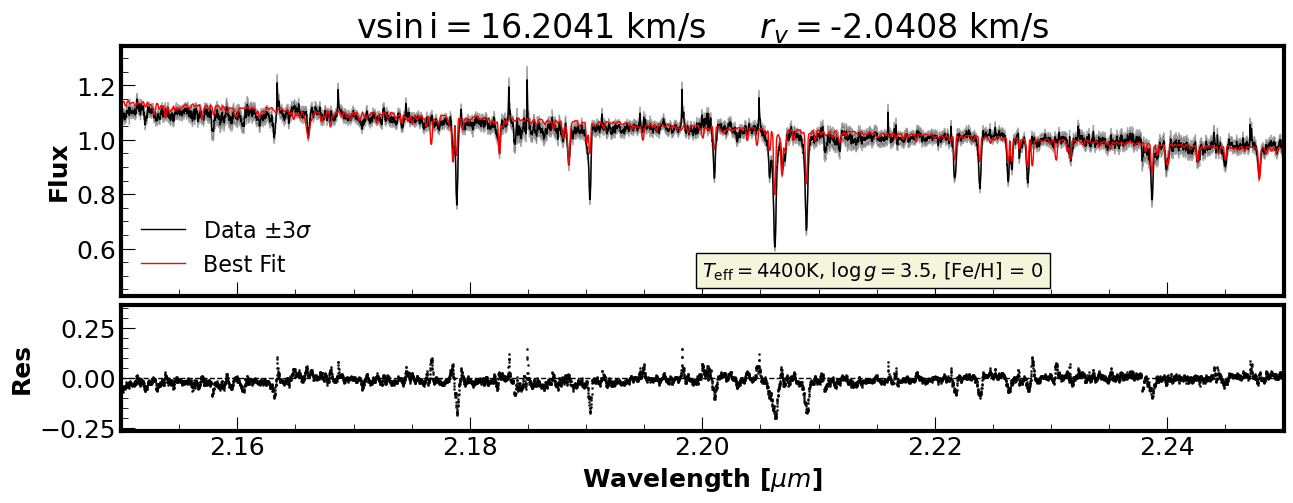

In [27]:
from matplotlib.gridspec import GridSpec

# Set up a figure with two panels (one for spectrum, one for residuals)
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0.05)  # GridSpec for proportional heights

ax0 = fig.add_subplot(gs[0])
ax0.plot(spec_list[spectrum_n].wavelength*1e-4, spec_list[spectrum_n].flux,
         lw=1,color='k',label=r'Data $\pm 3 \sigma$'
         )
ax0.fill_between(spec_list[spectrum_n].wavelength.value*1e-4,
                 spec_list[spectrum_n].flux.value - (3 * spec_list[spectrum_n].uncertainty.array),
                 spec_list[spectrum_n].flux.value + (3 * spec_list[spectrum_n].uncertainty.array),
                 color='k',
                 alpha=0.3)

ax0.plot(best_spec.wavelength*1e-4, best_spec.flux,
        lw=1, color='r', label='Best Fit'
        )

# Add text for parameters
ax0.text(2.2000, 0.5, rf'$T_{{\rm eff}}=${t_guess[spectrum_n]:.0f}K, $\log g =${logg_guess}, [Fe/H] = 0',
         color='black', bbox=dict(facecolor='beige', edgecolor='black', boxstyle='square,pad=0.3'),
         fontsize=14
         )

ax0.set_ylabel('Flux')
# Title and legend
ax0.set_title(rf"$\rm v\sin \rm i=${best_vsini:.4f} km/s $\quad$ $r_v=${best_rv:.4f} km/s")
ax0.legend(frameon=False, loc='best')

# Remove x-axis ticks for upper plot (shared axis with residuals)
ax0.tick_params(axis='x', labelbottom=False)  # Hides x-tick labels for the top panel only

# ---- Lower Panel: Residuals ----
ax1 = fig.add_subplot(gs[1], sharex=ax0)  # Share x-axis with the spectrum plot
ax1.scatter(spec_list[spectrum_n].wavelength*1e-4, residuals,s=1, color='k',alpha=0.75, label='Residuals')
ax1.axhline(0, color='k', linestyle='--', lw=1)  # Add horizontal line at zero for reference

# Labels for residuals plot
ax1.set_xlabel('Wavelength [$\mu m$]')
ax1.set_ylabel('Res')

plt.xlim(2.1500, 2.2500)
# Tight layout and show plot
# plt.tight_layout()
plt.show()

In [ ]:
STOP

In [ ]:
teff_grid = np.arange(3000,5700,100)
logg_grid = np.arange(0,6.5,0.5)

search_teff, search_logg = np.meshgrid(teff_grid, logg_grid, indexing='ij')

In [ ]:
@np.vectorize
# RSS to find best temperature and log g PHOENIX spectrum
def rss_temp_logg(teff, logg):
    model = PHOENIXSpectrum(teff=teff,
                            logg=logg,
                            Z=0,
                            wl_lo=wavmin,
                            wl_hi=wavmax,
                            path=phoenix_mod_path
                            ).resample(spec_list[spectrum_n])\
                            .normalize()
                            # .rotationally_broaden(vsini)\
                            # .rv_shift(rv)\
                            # .instrumental_broaden(45000)
    residual = spec_list[spectrum_n].flux - model.flux
    return np.nansum((residual)**2)

In [ ]:
loss_temp_logg = rss_temp_logg(search_teff, search_logg)

In [ ]:
# best indices
best_i, best_j = np.unravel_index(np.argmin(loss_temp_logg), 
                                  (len(teff_grid),len(logg_grid))
                                  )
best_temp, best_g = teff_grid[best_i], logg_grid[best_j]
best_temp, best_g

(np.int64(4300), np.float64(6.0))

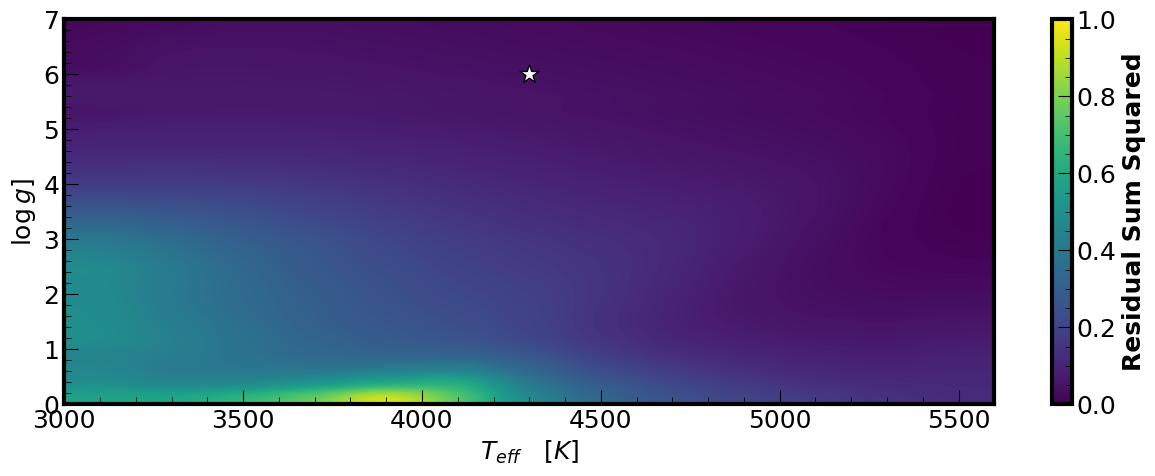

In [ ]:
plt.imshow(loss_temp_logg,
            extent=[teff_grid.min(), teff_grid.max(), logg_grid.min(), logg_grid.max()+1],
            aspect='auto',
            origin='lower',
            interpolation='gaussian'
            )
plt.scatter(best_temp, best_g,  marker='*', c='w', ec='k', s=200)

plt.colorbar(label='Residual Sum Squared')
plt.xlabel(r'$T_{eff} \quad [K]$')
plt.ylabel(r'$\log g]$')

plt.show()

In [ ]:
template_teff_logg = PHOENIXSpectrum(teff=best_temp,
                            logg=best_g,
                            Z=0,
                            wl_lo=wavmin,
                            wl_hi=wavmax,
                            path=phoenix_mod_path
                        ).instrumental_broaden(45000)\
                            .resample(spec_list[0])\
                            .normalize()

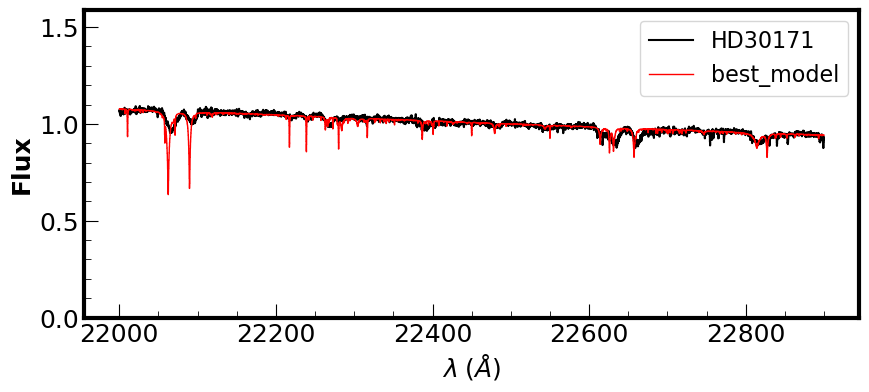

In [ ]:
ax = (spec_list[0]).plot(color='k',label=f"{standard_table['Name'][0]}")

(template_teff_logg).plot(ax=ax,label='best_model', color='r', zorder=20)

# ax.set_ylim(0,1.25)
# ax.set_xlim(22000,22100)
# ax.set_title(rf'$v\sin(i)$ = {best_vsini:0.0f} km/s, $v_r$ = {best_rv:0.1f} km/s')

plt.legend()
plt.show()

# Try to loop through one order of all standards

In [40]:
# na_reg_lines, ti_reg_lines, ca_reg_lines

In [60]:
spec_list = []
for i in tqdm(range(len(standard_table))):
    spec = IGRINSSpectrumList.read(standard_table['File'][i])\
        .trim_overlap().stitch()
    # spec = spec[10:-5]
    spec = spec.apply_boolean_mask(mask=(~np.isnan(spec.wavelength.value)) & 
                                    (spec.wavelength.value > 20040) & 
                                    (spec.wavelength.value < 23000)
                                    )#.smooth_spectrum(bandwidth=10)
    spec_list.append(spec.normalize())

100%|██████████| 23/23 [00:05<00:00,  4.00it/s]


In [61]:
check_wavmin = []
check_wavmax = []
for i in range(len(spec_list)):
    check_wavmin.append(spec_list[i].wavelength.value.min())
    check_wavmax.append(spec_list[i].wavelength.value.max())
print(np.min(check_wavmin), np.max(check_wavmax))

20040.005294676368 22999.978943432885


In [62]:
# for i in range(len(standard_table)):
#     spec_list[i].plot()

In [63]:
grid = PHOENIXGrid(
    teff_range = (teff_grid.min(),teff_grid.max()),
    logg_range = None,
    Z_range = (0, 0.1),
    wl_lo = 20040,
    wl_hi = 22120,
    path=phoenix_mod_path
    )

Processing Teff=5600K|log(g)=6.00|Z=+0.0: 100%|██████████| 351/351 [00:13<00:00, 26.95it/s]


In [64]:
teff_grid = np.arange(3000,5700,100)
logg_grid = np.arange(0,6.5,0.5)

vsinis = np.linspace(-50, 100, 20)
rvs = np.linspace(-100, 100, 20)

# grid = PHOENIXGrid(
#     teff_range = (teff_grid.min(),teff_grid.max()),
#     logg_range = None,
#     Z_range = (0, 0.1),
#     wl_lo = 21850,
#     wl_hi = 22290,
#     path=phoenix_mod_path
#     )

search_teff, search_logg = np.meshgrid(teff_grid, logg_grid, indexing='ij')
search_vsini, search_rv = np.meshgrid(vsinis, rvs, indexing='ij')

@np.vectorize
# RSS to find best temperature and log g PHOENIX spectrum
def rss_temp_logg(teff, logg, data):
    '''
    teff
    logg
    data = Spectrum1D
    '''
    model = PHOENIXSpectrum(teff=teff,
                            logg=logg,
                            Z=0,
                            wl_lo=22040,
                            wl_hi=22120,
                            path=phoenix_mod_path
                            ).resample(data)
                            # .normalize()
                            # .rotationally_broaden(vsini)\
                            # .rv_shift(rv)\
                            # .instrumental_broaden(45000)
    residual = np.abs(data.flux.value - model.flux.value)
    rss = np.nansum(residual**2)
    return rss

@np.vectorize
# RSS to find best rotational broadening vsini and radial velocity 
# AFTER doing an RSS to find best T_eff and logg
def rss_vels(vsini, rv, template, data):
    model = template.rotationally_broaden(vsini)\
                            .rv_shift(rv)\
                            .resample(data)\
                            .normalize()\
                            .instrumental_broaden(45000)
    residual = np.abs(data.flux.value - model.flux.value)
    rss = np.nansum(residual**2)
    return rss

In [ ]:
# Loop through the observed spectra
for i in tqdm(range(len(standard_table))):
    # 1. Find best T_eff and log g using the precomputed grid
    loss_tg = []
    for model in grid:  # grid is the list of Spectrum1D objects
        # Resample the model to match the observed spectrum
        model_resampled = model.resample(spec_list[i])
        # Calculate residual sum of squares (RSS)
        residual = np.abs(spec_list[i].flux.value - model_resampled.flux.value)
        rss = np.nansum(residual**2)
        loss_tg.append(rss)

    # Convert loss_tg to a grid shape
    loss_tg = np.array(loss_tg).reshape(len(teff_grid), len(logg_grid))
    loss_tg_list.append(loss_tg)

    # Find indices of the minimum loss
    best_i, best_j = np.unravel_index(np.argmin(loss_tg), loss_tg.shape)
    best_temp = teff_grid[best_i]
    best_g = logg_grid[best_j]

    # Save best parameters
    best_temp_list.append(best_temp)
    best_logg_list.append(best_g)

    # Use the best model from the grid
    best_template = grid[best_i * len(logg_grid) + best_j].normalize()
    template_list.append(best_template)

    # 2. Find best v_sini and radial velocity
    loss_vel = rss_vels(search_vsini, search_rv, best_template, spec_list[i])
    loss_vels_list.append(loss_vel)

    # Find indices of the minimum loss
    best_i, best_j = np.unravel_index(np.argmin(loss_vel), loss_vel.shape)
    best_vsini = vsinis[best_i]
    best_rv = rvs[best_j]

    # Save best parameters
    best_vsini_list.append(best_vsini)
    best_rv_list.append(best_rv)

    # 3. Generate final best-fit model
    best_model = (
        best_template.rotationally_broaden(best_vsini)
                     .rv_shift(best_rv)
                     .instrumental_broaden(45000)
                     .resample(spec_list[i])
                     .normalize()
    )
    best_model_list.append(best_model)

  0%|          | 0/23 [00:01<?, ?it/s]


NameError: name 'loss_tg_list' is not defined

IndexError: list index out of range

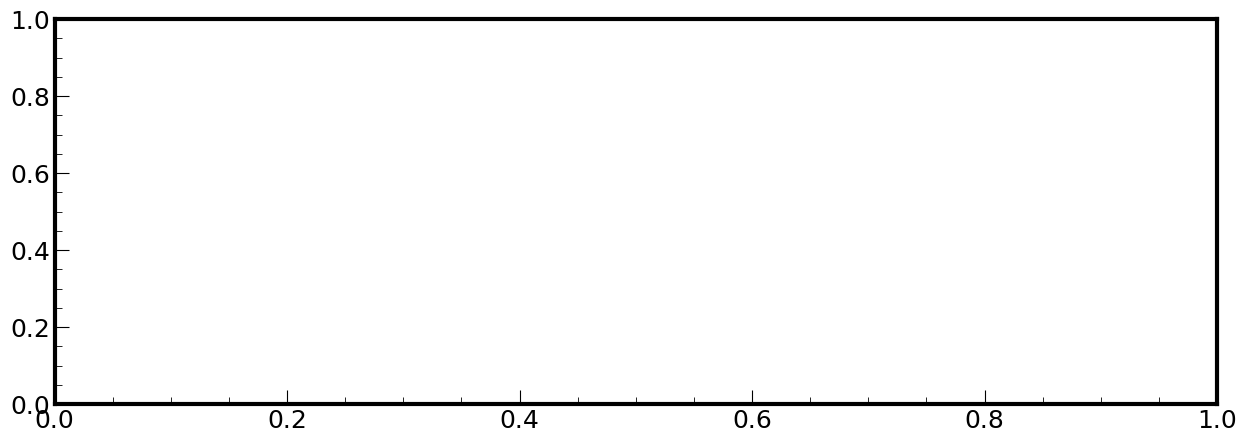

In [50]:
for i in range(len(spec_list)):
    fig, ax = plt.subplots(figsize=(15,5))
    template_list[i].normalize().plot(ax=ax)
    best_model_list[i].plot(ax=ax, color='r', zorder=10,label='Best Model')
    spec_list[i].plot(ax=ax,color='k',label=f"{standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")
    ax.legend()
# Add vertical lines for Na region lines
    for line in na_reg_lines:
        ax.axvline(x=line*1e4, ymin=0.01,ymax=0.99, color='k', linestyle='--', linewidth=1, zorder=1)

In [ ]:
# initialize lists
loss_tg_list = []
loss_vels_list = []
template_list = []
best_model_list = []
# list of best fit parameters
best_temp_list = []
best_logg_list = []
best_vsini_list = []
best_rv_list = []

for i in tqdm(range(len(standard_table))):
    # 1. Find best T_eff and log g
    loss_tg = rss_temp_logg(search_teff, search_logg, spec_list[i])
    loss_tg_list.append(loss_tg)

    # Find indices of the minimum loss
    best_i, best_j = np.unravel_index(np.argmin(loss_tg), loss_tg.shape)
    best_temp = teff_grid[best_i]
    best_g = logg_grid[best_j]

    # Save best parameters
    best_temp_list.append(best_temp)
    best_logg_list.append(best_g)

    # 2. Find best v_sini and radial velocity
    loss_vel = rss_vels(search_vsini, search_rv, grid[i], spec_list[i])
    loss_vels_list.append(loss_vel)

    # Find indices of the minimum loss
    best_i, best_j = np.unravel_index(np.argmin(loss_vel), loss_vel.shape)
    best_vsini = vsinis[best_i]
    best_rv = rvs[best_j]

    # Save best parameters
    best_vsini_list.append(best_vsini)
    best_rv_list.append(best_rv)

    # 3. Generate final best-fit model
    best_model = (
        grid[i].rotationally_broaden(best_vsini)
               .rv_shift(best_rv)
               .instrumental_broaden(45000)
               .resample(spec_list[i])
               .normalize()
    )
    best_model_list.append(best_model)

# for i in tqdm(range(len(standard_table))):
#     # rss to find best t_eff and log g
#     loss_tg = rss_temp_logg(search_teff, search_logg, spec_list[i])
#     loss_tg_list.append(loss_tg)

#     # best indices
#     best_i, best_j = np.unravel_index(np.argmin(loss_tg), (len(teff_grid),len(logg_grid)))
#     best_temp, best_g = teff_grid[best_i], logg_grid[best_j]

#     best_temp_list.append(best_temp)
#     best_logg_list.append(best_g)

#     template = PHOENIXSpectrum(teff=best_temp,
#                                 logg=best_g,
#                                 Z=0,
#                                 wl_lo=wavmin,
#                                 wl_hi=wavmax,
#                                 path=phoenix_mod_path
#                                 )
#     template_list.append(template)

#     loss_vel = rss_vels(search_vsini, search_rv, template, spec_list[i])
#     loss_vels_list.append(loss_vel)
#     # indices
#     best_i, best_j = np.unravel_index(np.argmin(loss_vel),(len(vsinis), len(rvs)))
#     best_vsini, best_rv = vsinis[best_i], rvs[best_j]

#     best_vsini_list.append(best_vsini)
#     best_rv_list.append(best_rv)

#     best_model = template.rotationally_broaden(best_vsini)\
#                                 .rv_shift(best_rv)\
#                                 .instrumental_broaden(45000)\
#                                 .resample(spec_list[i])\
#                                 .normalize()

#     best_model_list.append(best_model)

100%|██████████| 23/23 [08:26<00:00, 22.02s/it]


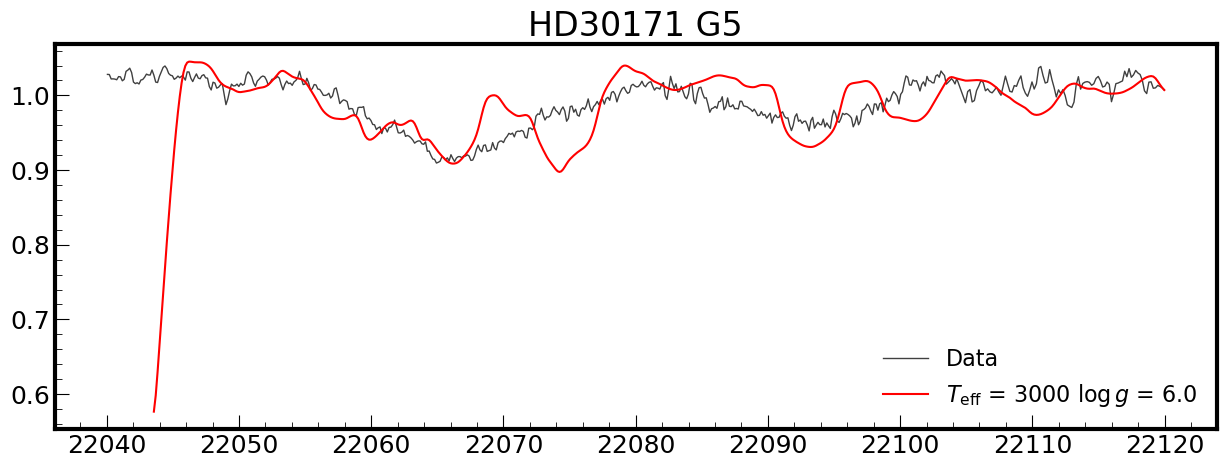

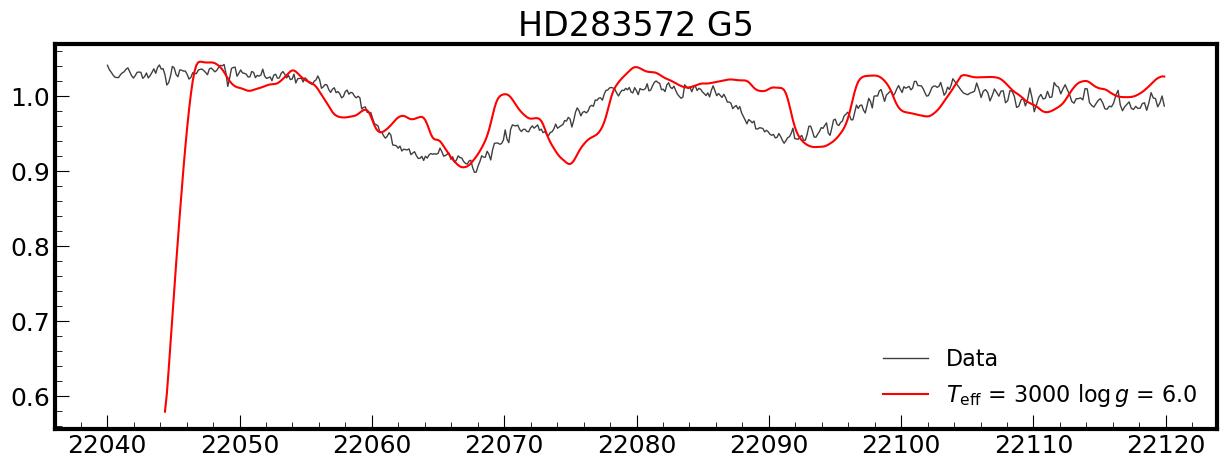

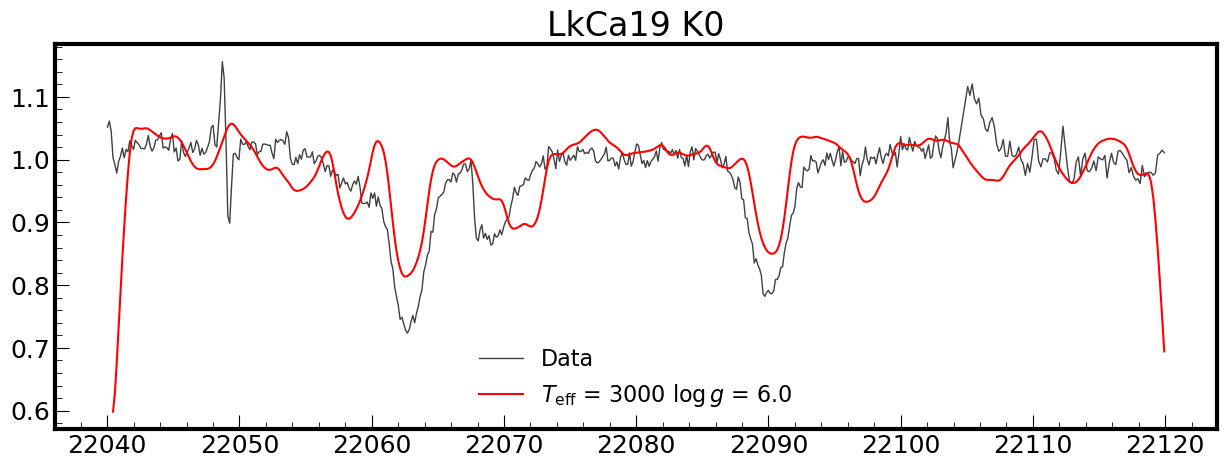

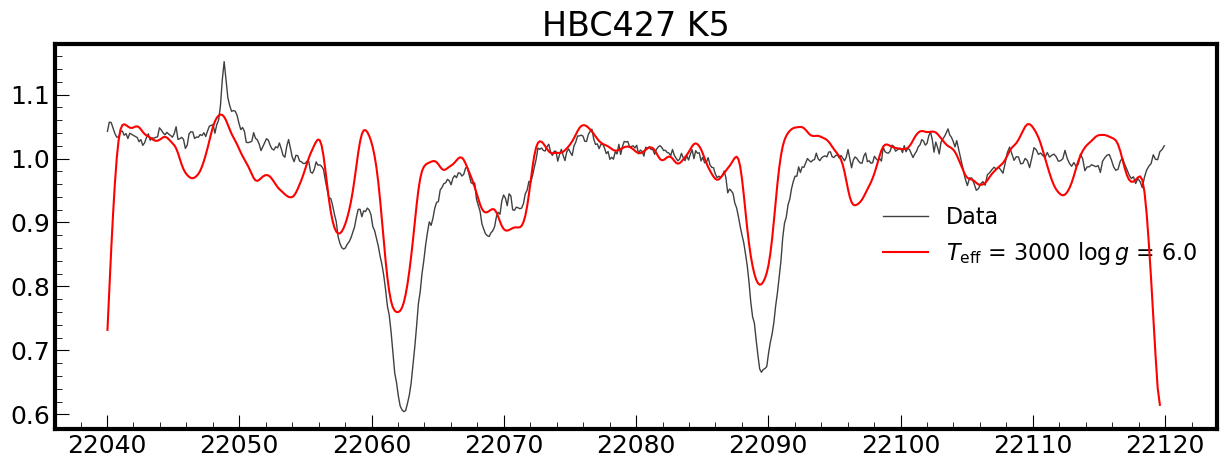

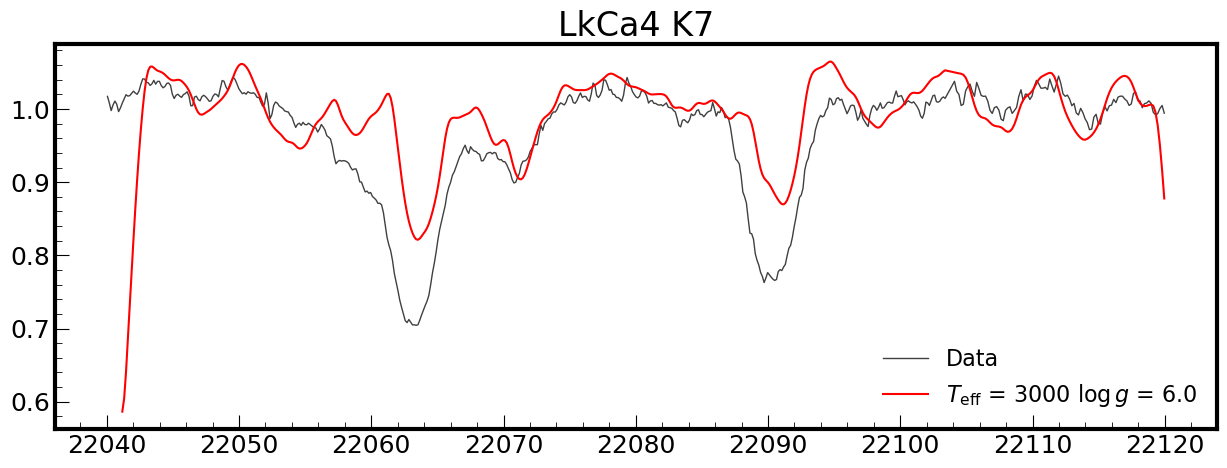

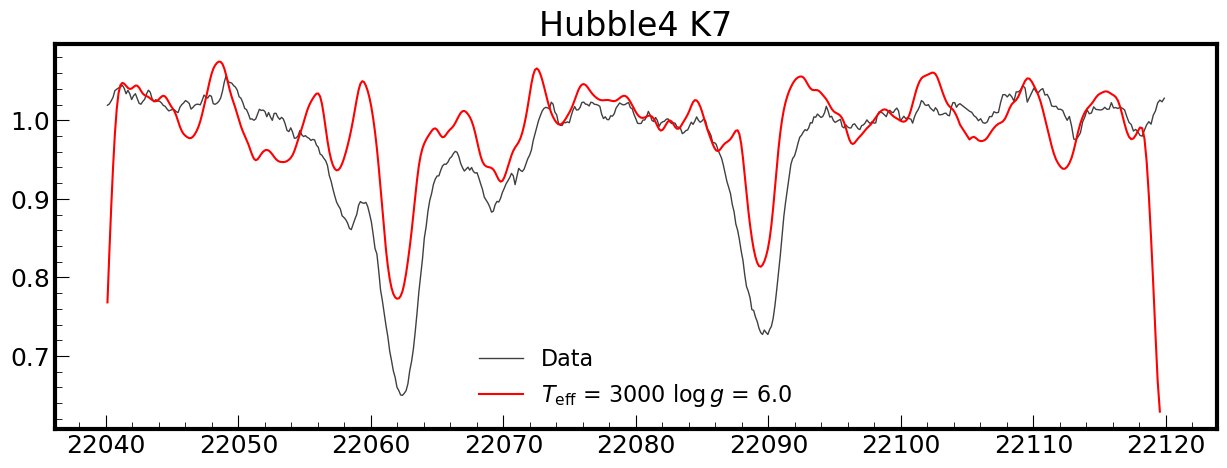

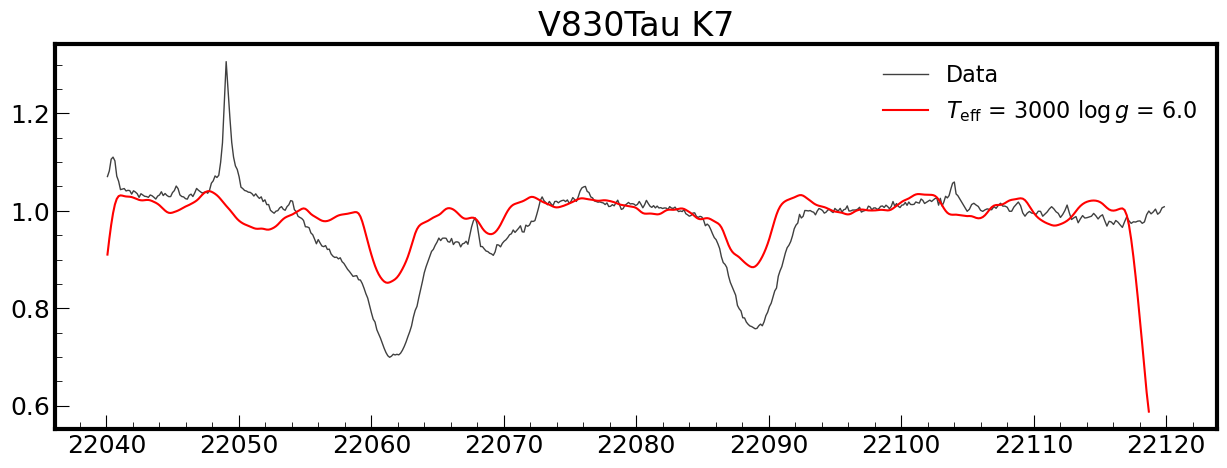

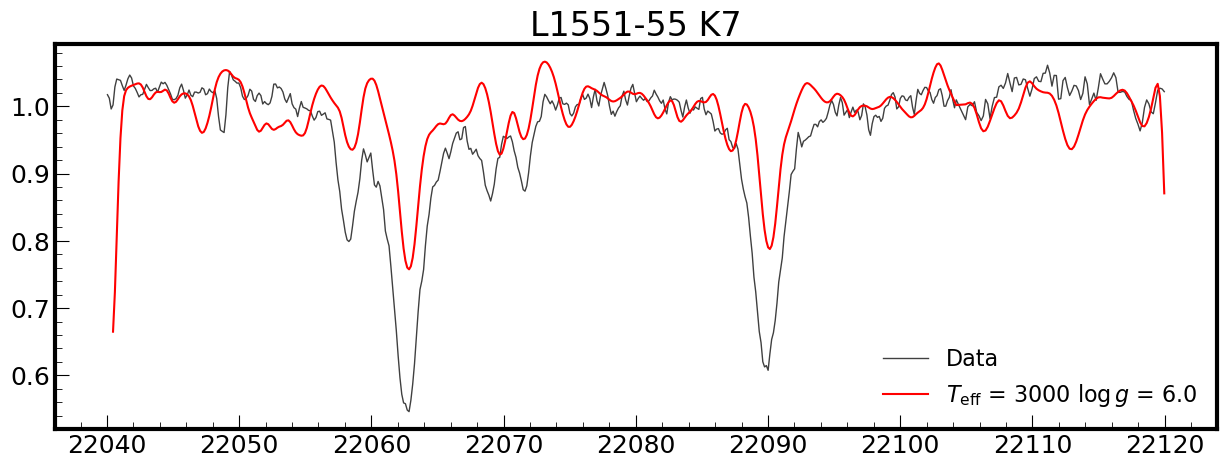

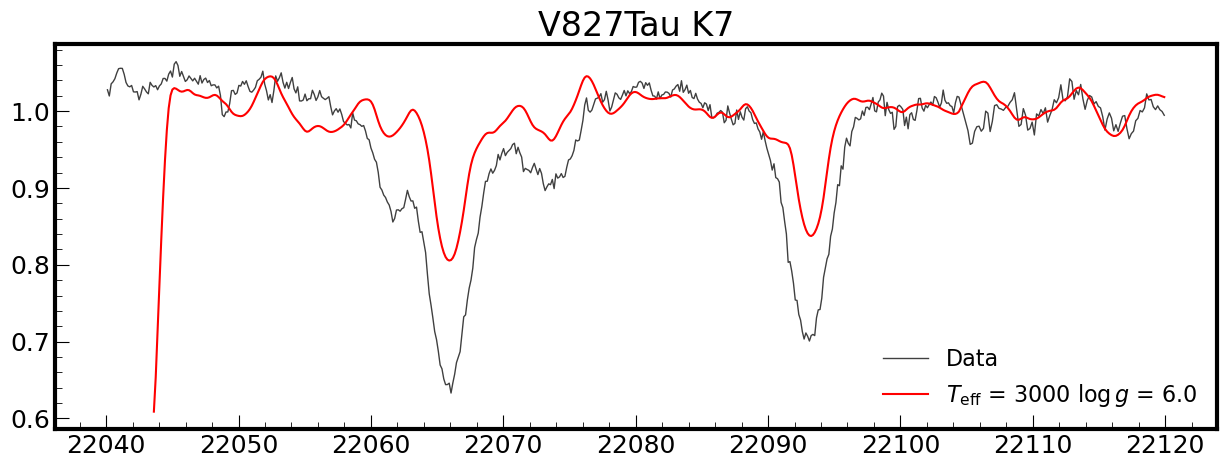

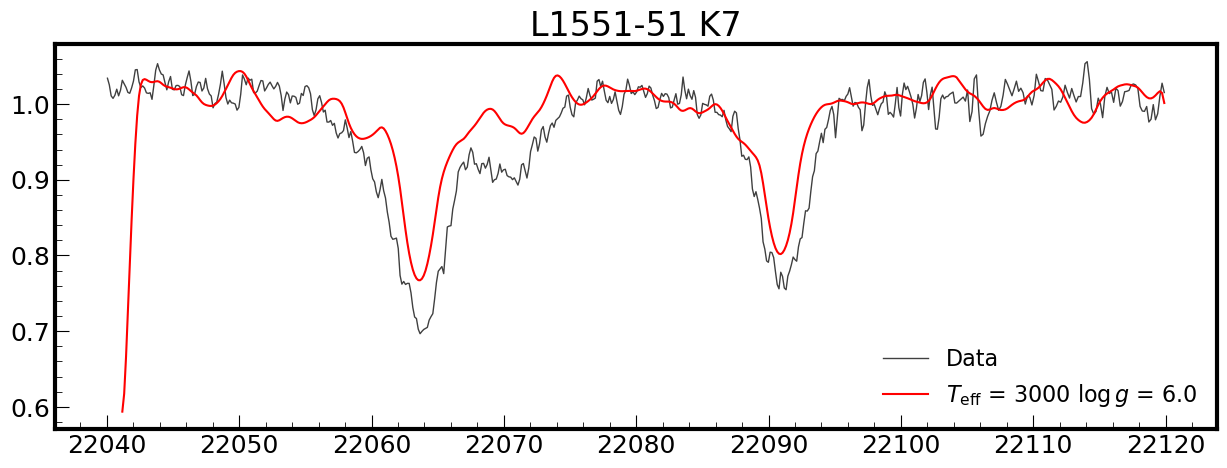

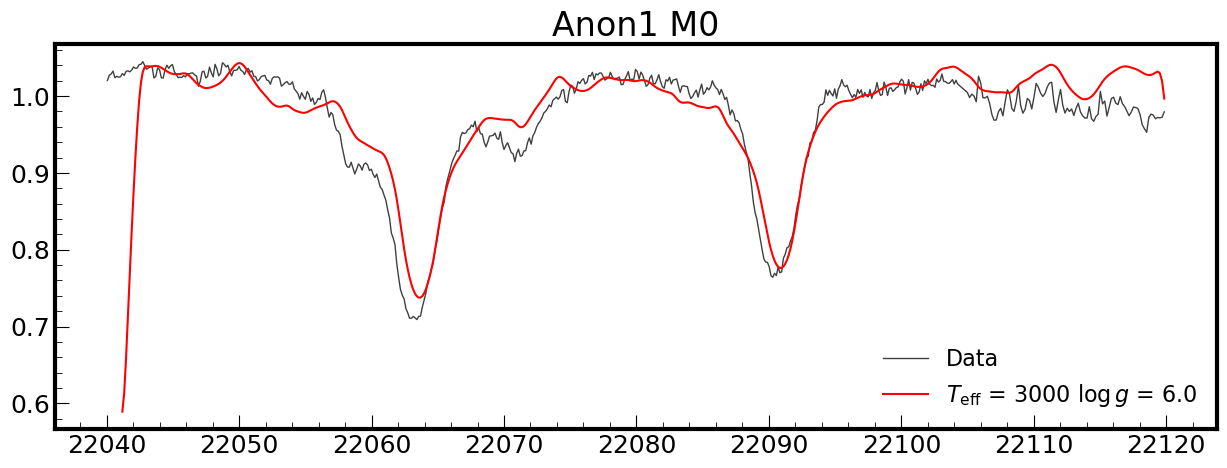

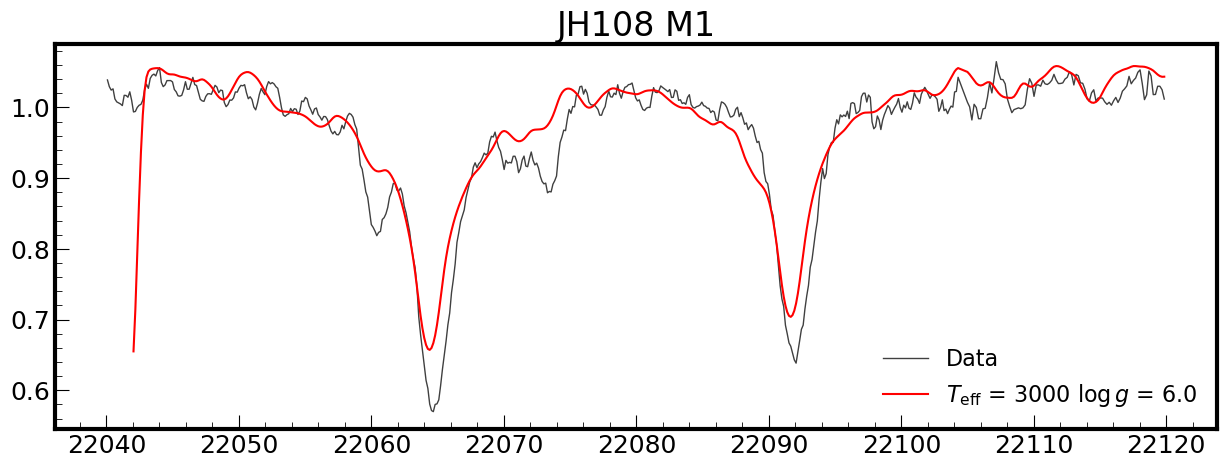

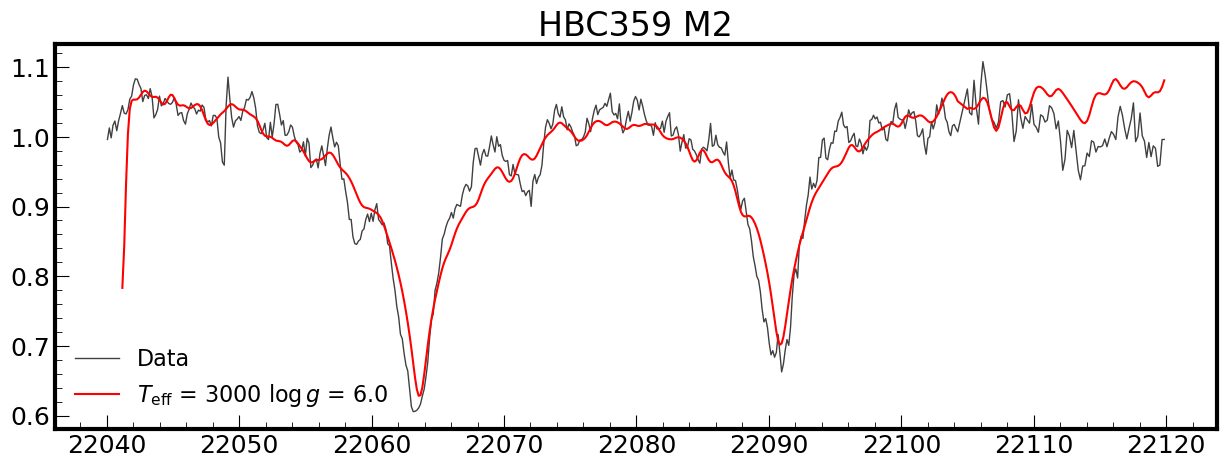

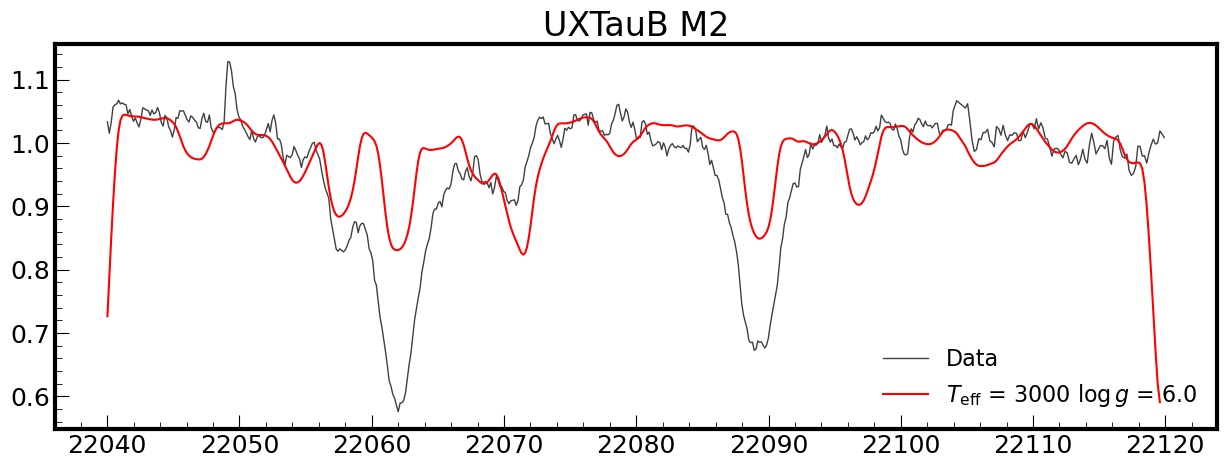

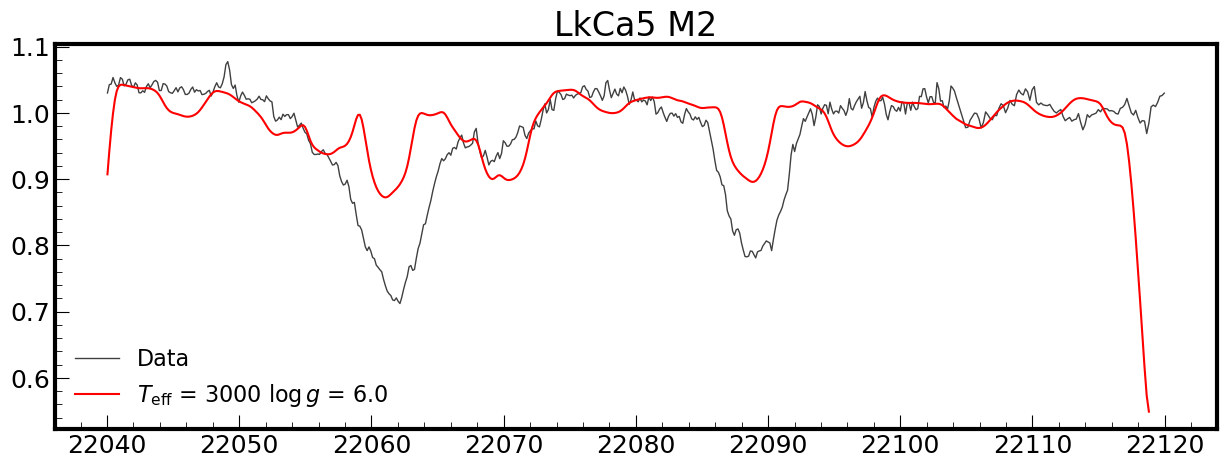

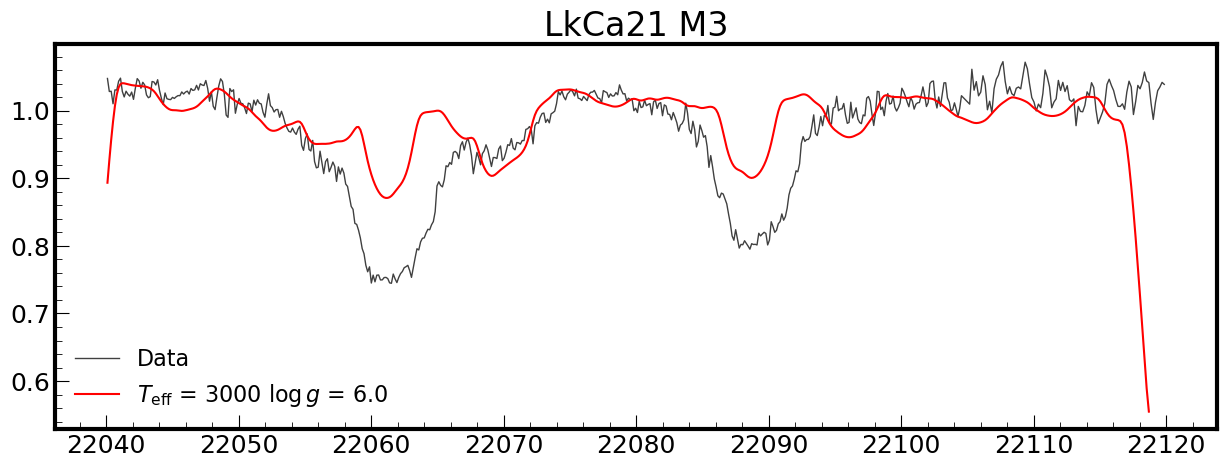

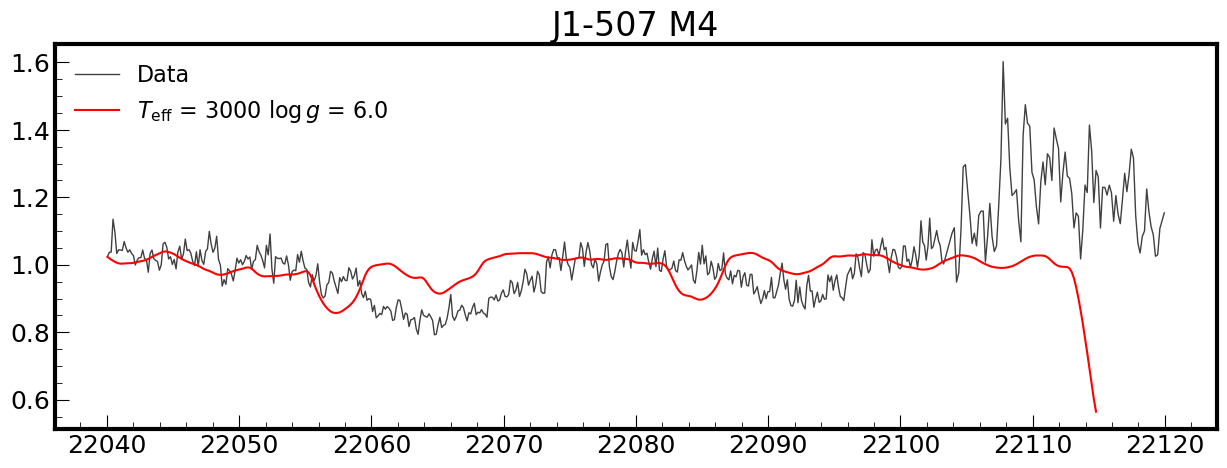

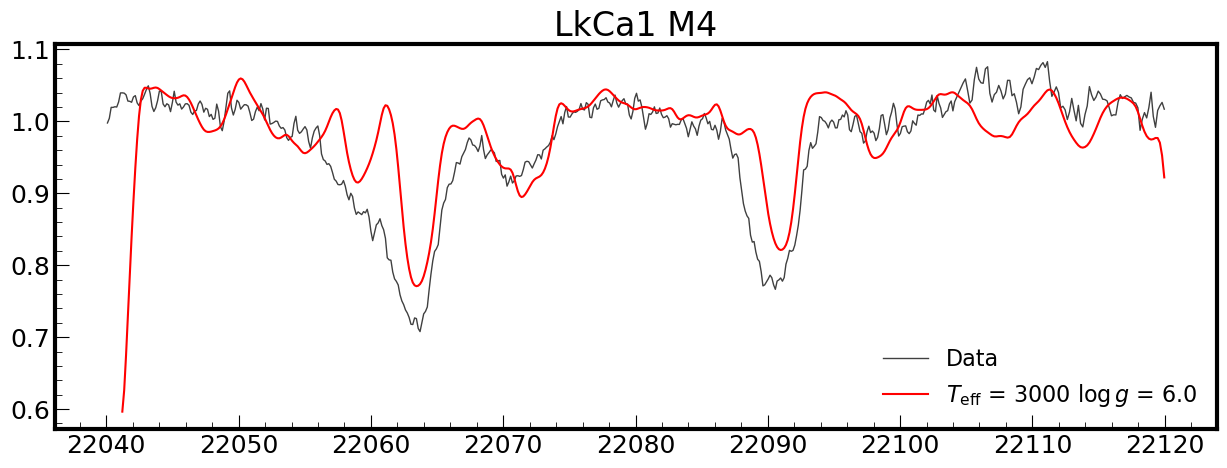

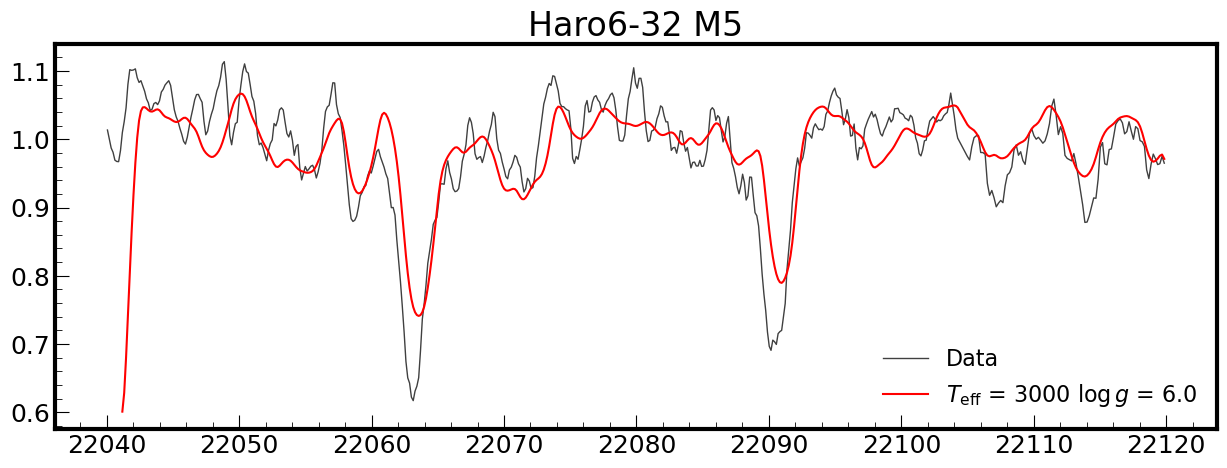

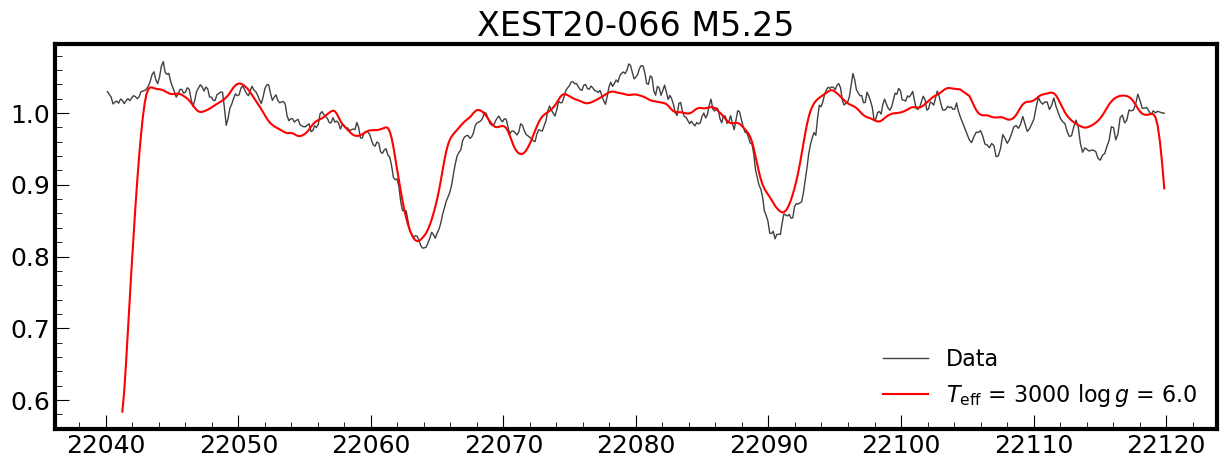

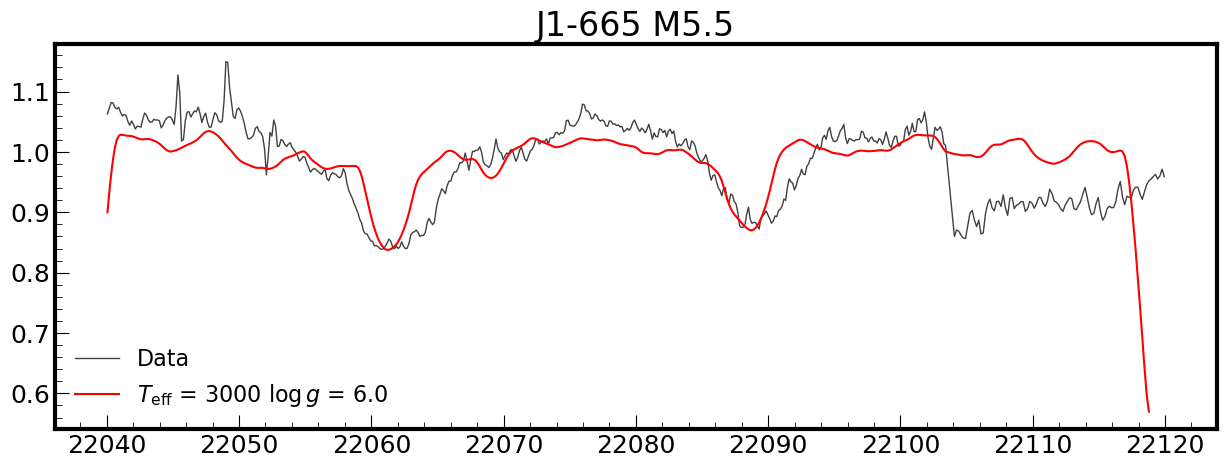

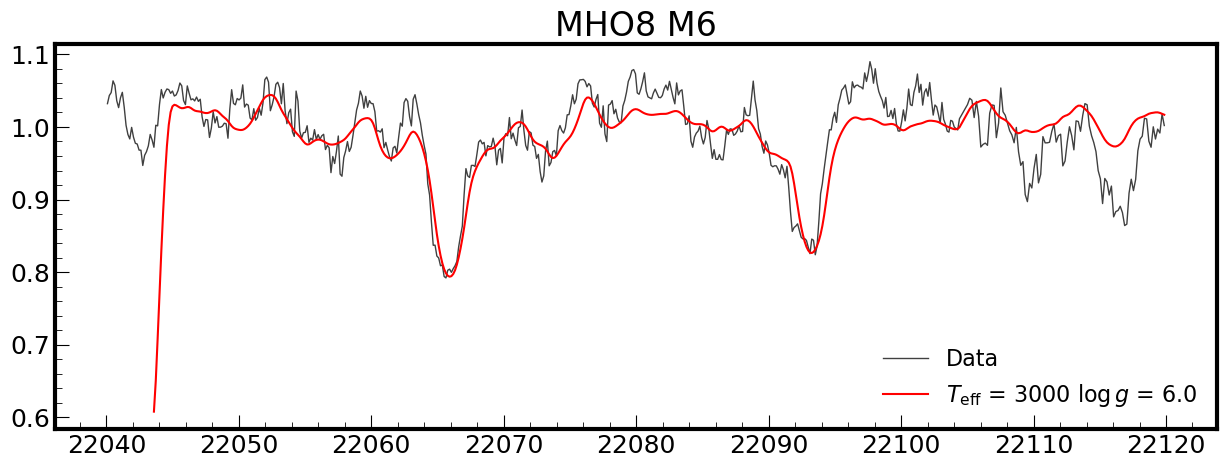

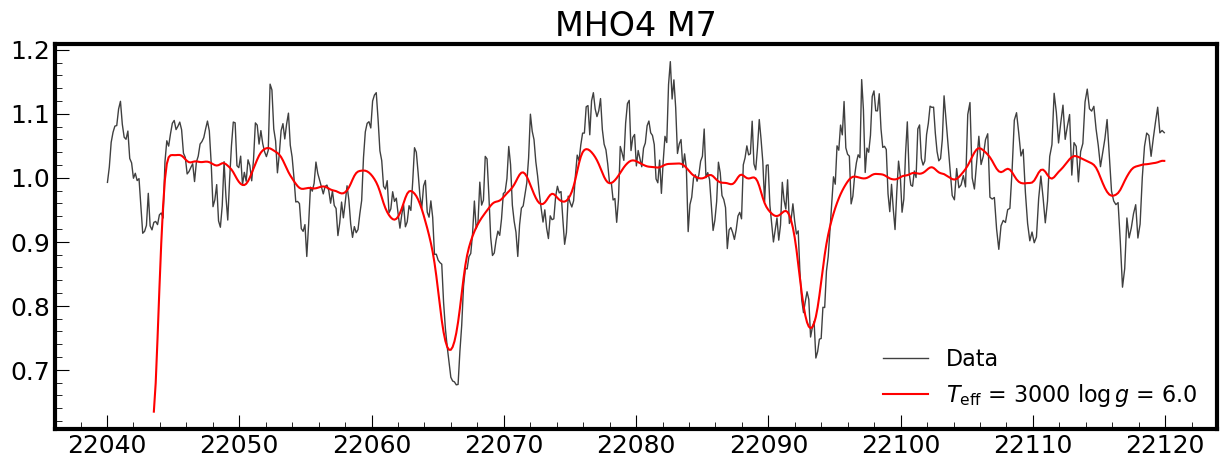

In [49]:
for i in range(len(standard_table)):
    fig = plt.figure(figsize=(15,5))
    plt.plot(spec_list[i].wavelength.value, spec_list[i].flux.value,
             lw=1,
             color='k',
             alpha=0.75,
             label=f"Data"
             )

    plt.plot(best_model_list[i].wavelength.value,best_model_list[i].flux.value,
                            color='r',
                            zorder=20,
                            label=rf"$T_{{\text{{eff}}}}$ = {best_temp_list[i]} $\log g$ = {best_logg_list[i]}"
                            )
    wave_max = spec_list[i].wavelength.value.max()
    wave_min = spec_list[i].wavelength.value.min()

    wave_sep = wave_max - wave_min
    mid_wave = wave_min + wave_sep/2
    
    # plt.text(x=mid_wave,
    #         y=0.7,s=rf"$v\sin i=${best_vsini_list[i]:.0f}km/s, $v_r=${best_rv_list[i]:.2f}km/s")

    plt.title(rf"{standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")
    plt.legend(frameon=False)

    ax.set_ylim(0.5,1.2)
# ax.set_xlim(22000,22650)
# plt.legend(frameon=False,bbox_to_anchor=(1,1))
plt.show()

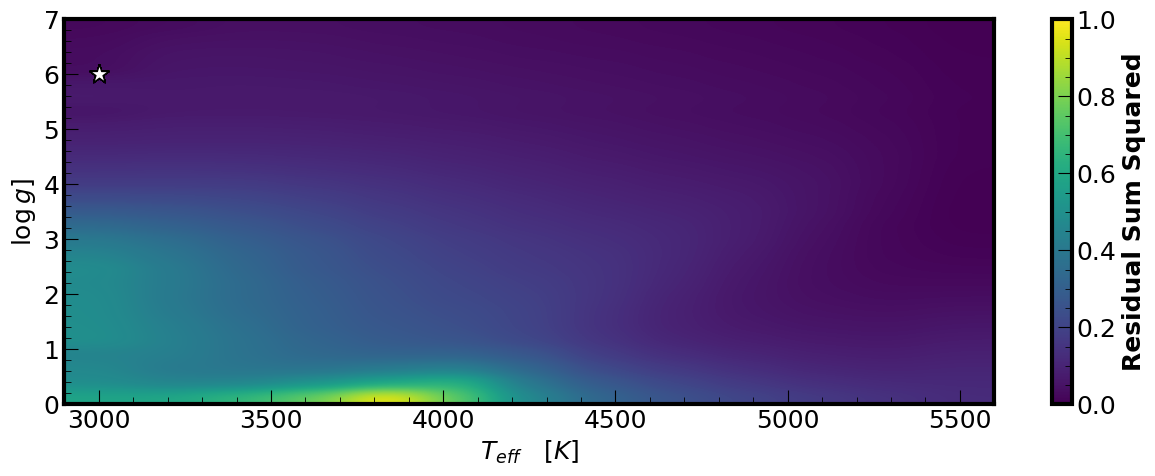

In [52]:
plt.imshow(loss_temp_logg,
            extent=[teff_grid.min()-100, teff_grid.max(), logg_grid.min(), logg_grid.max()+1],
            aspect='auto',
            origin='lower',
            interpolation='gaussian'
            )
plt.scatter(best_temp_list, best_logg_list,  marker='*', c='w', ec='k', s=200)

plt.colorbar(label='Residual Sum Squared')
plt.xlabel(r'$T_{eff} \quad [K]$')
plt.ylabel(r'$\log g]$')

plt.show()

# Attempt at $\chi^2$

In [ ]:
def chi_sq(obs_data,model_data):
    return np.nansum((obs_data-model_data)**2/model_data)

In [ ]:
chi_sq(spec_list[0].flux,template.flux)

# Fit PHOENIX Model to one order of IGRINS Spectra

In [ ]:
spec = IGRINSSpectrumList.read(standard_table['File'][0])[14]\
    .remove_nans().trim_edges(limits=(140,1948)).normalize()

# spec = spec_list[0].apply_boolean_mask(mask=(spec_list[0].wavelength.value > 21000) & (spec_list[0].wavelength.value < 23900)).normalize()

spec.plot()

In [ ]:
wavmin = np.round(np.nanmin(spec_list[0].wavelength.value))
wavmax = np.round(np.nanmax(spec_list[0].wavelength.value))

grid = PHOENIXGrid(teff_range=(2500, 7000),
                   logg_range=(0, 6),
                   Z_range=(0,0.1),
                   wl_lo=wavmin,
                   wl_hi=wavmax,
                   path=phoenix_mod_path
                  )

## Find Best Fit Parameters (WARNING: LONG RUNTIME)

In [ ]:
vsinis = np.linspace(1, 100, 20)  # v sin i range
rvs = np.linspace(-20, 30, 20)  # Radial velocity range

# Store best fit results
best_rss = np.inf
best_params = None
best_model = None

# Iterate over all grid points (Took ~90 minutes for one observed spectrum)
for grid_point in grid.grid_points:
    teff, logg, Z = grid_point  # Extract parameters for this grid point
    try:
        # Retrieve model spectrum using the grid point index
        index = grid.get_index(grid_point)
        # single model spectrum
        model_spectrum = grid[index]
        # normalize and resample wavelength grid to data
        model_spectrum = model_spectrum.normalize().resample(spec) 

        for vsini in vsinis:
            for rv in rvs:
                # Apply broadening and RV shift to model
                model = (
                    model_spectrum.rotationally_broaden(vsini)
                    .rv_shift(rv) # radial velocity shift
                    .instrumental_broaden(45000) # IGRINS Resolution
                    .resample(spec) # Resample wavelength grid
                    .normalize() # Normalize
                )

                # Compute Residual and Residual Sum Squared
                res = spec.flux - model.flux
                rss = np.nansum((res) ** 2)

                # Update best fit
                if rss < best_rss:
                    best_rss = rss
                    best_params = (teff, logg, Z, vsini, rv)
                    best_model = model

    except Exception as e:
        # handle errors for specific grid points
        print(f"Error with parameters Teff={teff}, logg={logg}, Z={Z}")
        print(e)

# Display results
best_teff, best_logg, best_Z, best_vsini, best_rv = best_params
print(f"Best fit parameters:\n"
      f"Teff: {best_teff} K\n"
      f"logg: {best_logg}\n"
      f"Z: {best_Z}\n"
      f"vsini: {best_vsini}\n"
      f"RV: {best_rv}")


In [ ]:
# res = spec_list[0].flux-best_model.flux

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,5), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

ax1.plot(spec.wavelength*1e-4, spec.flux, color='k',alpha=0.8, label='Observed Spectrum')
ax1.plot(best_model.wavelength*1e-4, best_model.flux, color='r', label='Best-Fitting Model', linestyle='--')

# ax1.set_xlim(2.2, 2.24)
# ax1.set_ylim(0.5, 1.5)

ax1.set_ylabel('Flux')
ax1.set_title(rf"$T=${best_teff} K, $\log g$ = {best_logg}, Z={best_Z}, $v \sin i=${best_vsini:.4f} km/s, $v_r=${best_rv:.4f} km/s")

ax2.scatter(best_model.wavelength*1e-4, res, color='r',s=1)

ax2.set_xlabel('Wavelength')
ax2.set_ylabel('res')

ax1.legend()
plt.show()

# Find Best Fit Parameters (WARNING: LONG RUNTIME)

In [ ]:
wavmin = np.round(np.nanmin(spec_list[0].wavelength.value))
wavmax = np.round(np.nanmax(spec_list[0].wavelength.value))

grid = PHOENIXGrid(teff_range=(2500, 7000),
                   logg_range=(0, 6),
                   Z_range=(0,0.1),
                   wl_lo=wavmin,
                   wl_hi=wavmax,
                   path=phoenix_mod_path
                  )

In [ ]:
vsinis = np.linspace(1, 100, 20)  # v sin i range
rvs = np.linspace(-20, 30, 20)  # Radial velocity range

# Store best fit results
best_rss = np.inf
best_params = None
best_model = None

# Iterate over all grid points (Took ~90 minutes for one observed spectrum)
for grid_point in grid.grid_points:
    teff, logg, Z = grid_point  # Extract parameters for this grid point
    try:
        # Retrieve model spectrum using the grid point index
        index = grid.get_index(grid_point)
        model_spectrum = grid[index]
        model_spectrum = model_spectrum.normalize().resample(spec_list[0]) # normalize and resample wavelength grid to data

        for vsini in vsinis:
            for rv in rvs:
                # Apply broadening and RV shift
                model = (
                    model_spectrum.rotationally_broaden(vsini)
                    .rv_shift(rv) # radial velocity
                    .instrumental_broaden(45000) # IGRINS Resolution
                    .resample(spec_list[0]) # Resample
                    .normalize() # Normalize
                )

                # Compute Residual Sum Squared
                res = spec_list[0].flux - model.flux
                rss = np.nansum((res) ** 2)

                # Update best fit
                if rss < best_rss:
                    best_rss = rss
                    best_params = (teff, logg, Z, vsini, rv)
                    best_model = model

    except Exception as e:
        # handle errors for specific grid points
        print(f"Error with parameters Teff={teff}, logg={logg}, Z={Z}")
        print(e)

# Display results
best_teff, best_logg, best_Z, best_vsini, best_rv = best_params
print(f"Best fit parameters:\n"
      f"Teff: {best_teff} K\n"
      f"logg: {best_logg}\n"
      f"Z: {best_Z}\n"
      f"vsini: {best_vsini}\n"
      f"RV: {best_rv}")


In [ ]:
res = spec_list[0].flux-best_model.flux

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(15,5), gridspec_kw={'height_ratios': [4, 1]}, sharex=True)

ax1.plot(spec_list[0].wavelength*1e-4, spec_list[0].flux, color='k',alpha=0.8, label='Observed Spectrum')
ax1.plot(best_model.wavelength*1e-4, best_model.flux, color='r', label='Best-Fitting Model', linestyle='--')

# ax1.set_xlim(2.2, 2.24)
# ax1.set_ylim(0.5, 1.5)

ax1.set_ylabel('Flux')
ax1.set_title(rf"$T=${best_teff} K, $\log g$ = {best_logg}, Z={best_Z}, $v \sin i=${best_vsini:.4f} km/s, $v_r=${best_rv:.4f} km/s")

ax2.scatter(best_model.wavelength*1e-4, res, color='r',s=1)
# ax2.set_ylim(-0.3,0.3)
ax2.set_xlabel('Wavelength')
ax2.set_ylabel('res')

ax1.legend()
plt.show()